In [1]:
!pip install bayesian-optimization
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 9.4 MB/s eta 0:00:00


# Import Necessary Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as main_datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import random
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from bayes_opt import BayesianOptimization
from skorch import NeuralNetClassifier

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Question 1-1
-   Loading Fashion-MNIST dataset using torch vision
-   Implementing MLP with one layer
-   Confusion Matrx for model

## Loading Fashion-MNIST dataset

In [4]:
transform = transforms.ToTensor()

In [5]:
train_dataset = main_datasets.FashionMNIST(root='./fmnist', train=True, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 8.92MB/s]


Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 164kB/s]


Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.10MB/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



In [6]:
test_set = main_datasets.FashionMNIST(root='./test_fashion', train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.88MB/s]


Extracting ./test_fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./test_fashion/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 83.8kB/s]


Extracting ./test_fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./test_fashion/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:03<00:00, 1.22MB/s]


Extracting ./test_fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./test_fashion/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.3MB/s]

Extracting ./test_fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./test_fashion/FashionMNIST/raw



In [7]:
def plotting_sample(sample:torch.tensor, title:str) -> None:
    """
    Plotting a given sample from fashion mnist
    Parameter:
    -   sample: tensor vector
    -   title: string for clarifying title
    Return:
        Plotted Image for corresponding sample
    """
    plt.figure(figsize=(8, 6))
    image_numpy = sample.numpy().squeeze()
    plt.imshow(image_numpy, cmap='gray')
    plt.axis('off')
    plt.title(f"{title}")
    plt.tight_layout()
    plt.show()

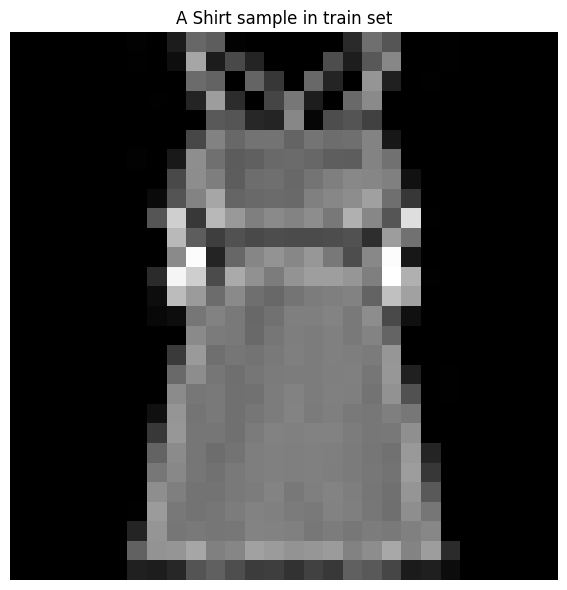

In [8]:
idx_to_class = {value:key for key, value in train_dataset.class_to_idx.items()}
random.seed(42)
index_sample = random.randint(0, len(train_dataset))
sample, sample_cls = train_dataset[index_sample]
label = idx_to_class[sample_cls]
title = f"A {label} sample in train set"
plotting_sample(sample=sample, title=title)

## Implementing the MLP with one layer

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
iteration = iter(train_dataloader)
first_batch = next(iteration)
images, labels = first_batch
print(f"Images per batch: {images.shape}")
print(f"labels per batch: {labels.shape}")
x = images.squeeze(1)
print(x.reshape(x.shape[0], -1).shape)

Images per batch: torch.Size([64, 1, 28, 28])
labels per batch: torch.Size([64])
torch.Size([64, 784])


In [ ]:
class MLP_one_hidden_layer(nn.Module):
    def __init__(self, hidden_dimension:int, drop_out:float) -> torch.nn:
        """
        This function will create an object for our model.
        Parameters:
            - hidden_dimension : hidden layer dimension.
            - dropout : a float number specifing what precentage should be dropped.
        Return :
            Object of torch.nn
        """
        super().__init__()
        self.hidden_layer = nn.Linear(28*28, hidden_dimension)
        self.dropout = nn.Dropout(p=drop_out)
        self.relu = nn.ReLU()
        self.clf = nn.Linear(hidden_dimension, 10)

    def forward(self, x:torch.Tensor):
        """
        First reshape the input to [batch_size, 28*28]
        Then apply our model!
        """
        x = x.view(x.size(0), -1)
        x = self.relu(self.hidden_layer(x))
        x = self.dropout(x)
        return self.clf(x)

In [ ]:
params = {
    "hidden_dimension": 100,
    "drop_out": 0.3,
    "l2_regularization": 0.0001,
}

In [ ]:
model = MLP_one_hidden_layer(hidden_dimension=params["hidden_dimension"], drop_out=params["drop_out"])
model.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=100, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=100, out_features=10, bias=True)
)

### Applying regularization just on hidden layer

In [ ]:
optimizer = optim.SGD([
    {'params': model.hidden_layer.weight, 'weight_decay': params["l2_regularization"]},
    {'params': [model.hidden_layer.bias, model.clf.weight, model.clf.bias], 'weight_decay': 0.0}
], lr=0.005)

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
def testing(dataloader:DataLoader, model:nn.Module, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    test_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = loss_fn(preds, labels.to(torch.long))
            test_loss += loss.item()
            probs = F.softmax(preds, dim=1)
            _, predicted_indices = torch.max(preds, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average="micro")
    all_labels_one_hot = F.one_hot(torch.tensor(all_labels), num_classes=probs.shape[1]).numpy()
    macro_auc = roc_auc_score(all_labels_one_hot, all_probs, multi_class='ovr', average='micro')
    print(f'Test Loss: {test_loss/len(dataloader):.2f}, Test Accuaracy: {accuracy:.2f}, Micro AUC: {macro_auc:.2f}, F1 Micro: {f1_micro:.2f}')
    return test_loss/len(dataloader), accuracy, all_preds, all_labels

In [12]:
def training(train_loader:DataLoader, test_loader:DataLoader, optimizer:optim, model:nn.Module, epochs:int, loss_fn):
    model.train()
    training_loss_per_epoch = []
    accuracy_per_epoch = []
    test_loss_per_epoch = []
    test_acc_per_epoch = []
    for epoch in range(epochs):
        training_loss = 0.0
        model.train()
        all_preds = []
        all_labels = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = loss_fn(preds, labels.to(torch.long))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted_indices = torch.max(preds, dim=1)
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        training_loss = training_loss / len(train_loader)
        training_loss_per_epoch.append(training_loss)
        accuracy_per_epoch.append(accuracy_score(all_labels, all_preds))
        print(f'Epoch: {epoch}, training_loss: {training_loss:.2f}, training_accuracy: {accuracy_score(all_labels, all_preds):.2f}')
        test_loss, test_acc, test_all_labels, test_all_preds = testing(test_loader, model, loss_fn)
        test_loss_per_epoch.append(test_loss)
        test_acc_per_epoch.append(test_acc)
    return training_loss_per_epoch, accuracy_per_epoch, test_loss_per_epoch, test_acc_per_epoch ,test_all_labels, test_all_preds

In [ ]:
epochs= 40
train_loss, train_acc, test_loss, test_acc, test_labels, test_preds = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=optimizer, model=model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.52, training_accuracy: 0.52
Test Loss: 1.01, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.93, training_accuracy: 0.68
Test Loss: 0.80, Test Accuaracy: 0.72, Micro AUC: 0.97, F1 Micro: 0.72


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.79, training_accuracy: 0.73
Test Loss: 0.72, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.72, training_accuracy: 0.75
Test Loss: 0.66, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.67, training_accuracy: 0.77
Test Loss: 0.62, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.60, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.61, training_accuracy: 0.79
Test Loss: 0.57, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.41, training_accuracy: 0.85
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


### Plotting loss

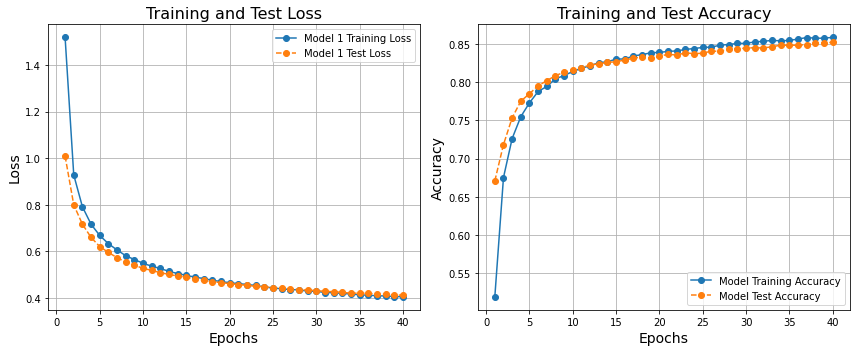

In [ ]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Model Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc, label='Model Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Test Accuracy', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_preds)
print(cf_matrix)

[[829   3  19  33   0   0 157   0   1   0]
 [  3 960   5  11   1   0   2   0   1   0]
 [ 15   6 758  15 109   0 111   0   9   0]
 [ 36  23   9 867  33   1  34   0   7   0]
 [  4   4 125  31 769   0  88   0   3   0]
 [  0   0   1   1   0 915   0  30   3   8]
 [ 97   2  75  34  76   0 581   0  14   0]
 [  0   0   0   0   0  46   0 927   5  42]
 [ 15   2   8   6   8   3  26   0 956   1]
 [  0   0   0   0   0  33   0  42   0 945]]


### Plot with heatmap

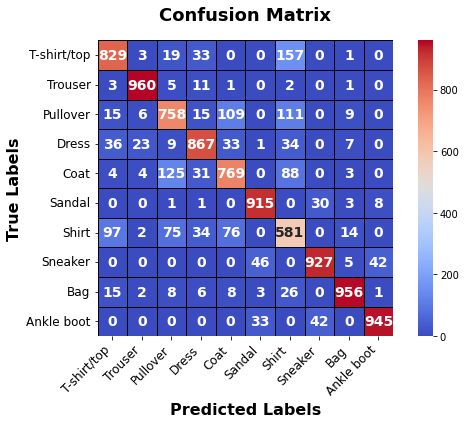

In [ ]:
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

## How to complex models(higher neurons or higher layers) can improve efficiency?

In [ ]:
class MLP_two_hidden_layers(nn.Module):
    def __init__(self, first_hidden_dimension:int, second_hidden_dimension:int, dropout:float) -> None:
        """
        Creating an object for our model
        Parameter:
            -   first_hidden_dimension: Specifying the dimension of first hidden layer
            -   second_hidden_dimension: Specifying the dimension of second hidden layer
            -   dropout: A float number for turn off random neurons
        Return:
            An object of nn.Module of torch
        """
        super().__init__()
        self.hidden_1 = nn.Linear(28*28, first_hidden_dimension)
        self.hidden_2 = nn.Linear(first_hidden_dimension, second_hidden_dimension)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.clf = nn.Linear(second_hidden_dimension, 10)

    def forward(self, x:torch.Tensor):
        """
        First reshape data to [batch_size, 28*28]
        Pass through first hidden layer
        Pass through second hidden layer
        Classify at the end
        """
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.hidden_1(x)))
        x = self.dropout(self.relu(self.hidden_2(x)))
        return self.clf(x)

In [ ]:
second_params = {
    "first_hidden_dimension": 200,
    "second_hidden_dimension": 100,
    "dropout": 0.3,
    "l2_regularization": 0.0001,
}

In [ ]:
sec_model = MLP_two_hidden_layers(
    first_hidden_dimension=second_params["first_hidden_dimension"],
    second_hidden_dimension=second_params["second_hidden_dimension"],
    dropout=second_params["dropout"]
)
sec_model.to(device=device)
sec_model

MLP_two_hidden_layers(
  (hidden_1): Linear(in_features=784, out_features=200, bias=True)
  (hidden_2): Linear(in_features=200, out_features=100, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
second_optimizer = optim.SGD([
    {'params': [sec_model.hidden_1.weight, sec_model.hidden_2.weight], 'weight_decay': second_params["l2_regularization"]},
    {'params': [sec_model.hidden_1.bias, sec_model.hidden_2.bias, model.clf.weight, model.clf.bias], 'weight_decay': 0.0}
], lr=0.005)

In [ ]:
epochs= 40
train_loss, train_acc, test_loss, test_acc, test_labels, test_preds = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=second_optimizer, model=sec_model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 2.03, training_accuracy: 0.38
Test Loss: 1.62, Test Accuaracy: 0.56, Micro AUC: 0.91, F1 Micro: 0.56


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.43, training_accuracy: 0.52
Test Loss: 1.15, Test Accuaracy: 0.63, Micro AUC: 0.95, F1 Micro: 0.63


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.16, training_accuracy: 0.58
Test Loss: 0.97, Test Accuaracy: 0.66, Micro AUC: 0.96, F1 Micro: 0.66


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 1.03, training_accuracy: 0.62
Test Loss: 0.88, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.96, training_accuracy: 0.65
Test Loss: 0.83, Test Accuaracy: 0.69, Micro AUC: 0.97, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.90, training_accuracy: 0.67
Test Loss: 0.79, Test Accuaracy: 0.71, Micro AUC: 0.97, F1 Micro: 0.71


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.86, training_accuracy: 0.69
Test Loss: 0.75, Test Accuaracy: 0.73, Micro AUC: 0.97, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.82, training_accuracy: 0.71
Test Loss: 0.72, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.79, training_accuracy: 0.72
Test Loss: 0.70, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.77, training_accuracy: 0.73
Test Loss: 0.68, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.75, training_accuracy: 0.74
Test Loss: 0.66, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.73, training_accuracy: 0.75
Test Loss: 0.64, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.71, training_accuracy: 0.76
Test Loss: 0.63, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.69, training_accuracy: 0.76
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.68, training_accuracy: 0.77
Test Loss: 0.60, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.67, training_accuracy: 0.77
Test Loss: 0.59, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.66, training_accuracy: 0.78
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.64, training_accuracy: 0.78
Test Loss: 0.57, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.57, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.61, training_accuracy: 0.79
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.61, training_accuracy: 0.79
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


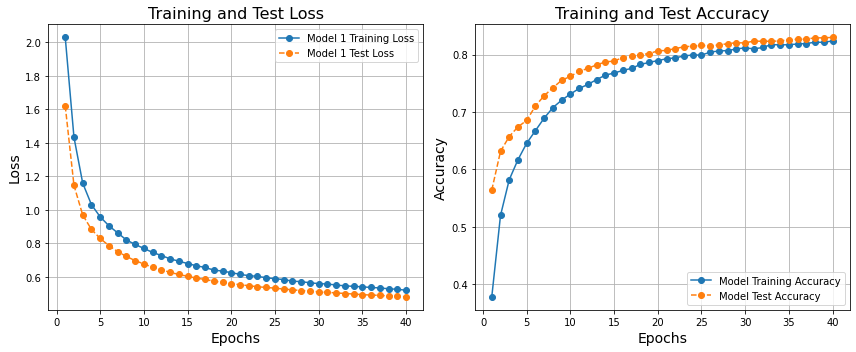

In [ ]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Model Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc, label='Model Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Test Accuracy', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

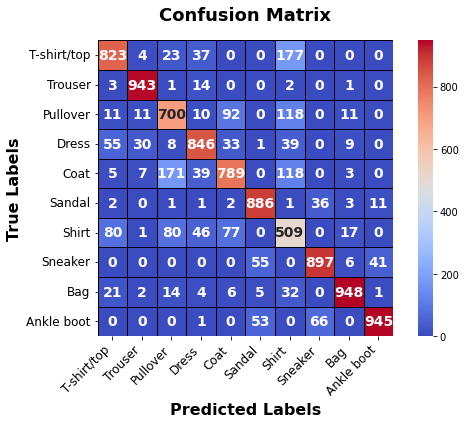

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_preds)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
third_params = {
    "hidden_dimension": 200,
    "drop_out": 0.3,
    "l2_regularization": 0.0001,
}

In [ ]:
third_model = MLP_one_hidden_layer(hidden_dimension=third_params["hidden_dimension"], drop_out=params["drop_out"])
third_model.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=200, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
third_optimizer = optim.SGD([
    {'params': third_model.hidden_layer.weight, 'weight_decay': params["l2_regularization"]},
    {'params': [third_model.hidden_layer.bias, third_model.clf.weight, third_model.clf.bias], 'weight_decay': 0.0}
], lr=0.005)

In [ ]:
epochs= 40
train_loss, train_acc, test_loss, test_acc, test_labels, test_preds = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=third_optimizer, model=third_model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.48, training_accuracy: 0.55
Test Loss: 0.99, Test Accuaracy: 0.68, Micro AUC: 0.96, F1 Micro: 0.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.89, training_accuracy: 0.69
Test Loss: 0.78, Test Accuaracy: 0.73, Micro AUC: 0.97, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.76, training_accuracy: 0.74
Test Loss: 0.70, Test Accuaracy: 0.75, Micro AUC: 0.98, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.69, training_accuracy: 0.76
Test Loss: 0.65, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.64, training_accuracy: 0.78
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.61, training_accuracy: 0.79
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


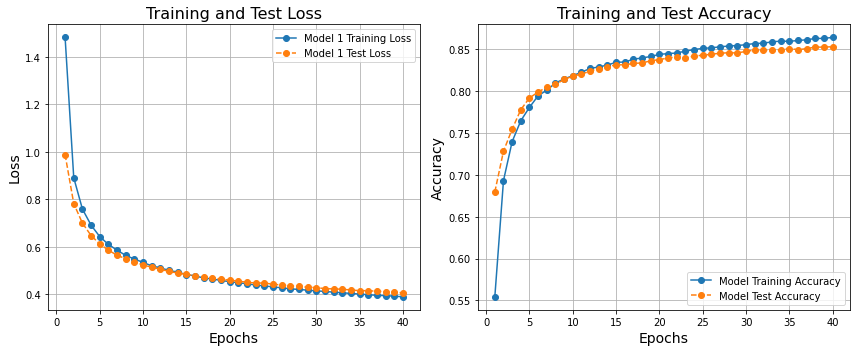

In [ ]:
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Model Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc, label='Model Test Accuracy', linestyle='--', marker='o')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Test Accuracy', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

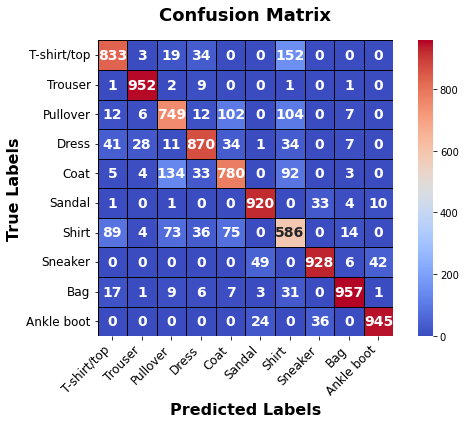

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_preds)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Question 1-2
- Create 2 different model
- Histogram
- RMSprop, Adam

In [ ]:
model_1 = MLP_one_hidden_layer(hidden_dimension=128, drop_out=0)
model_2 = MLP_one_hidden_layer(hidden_dimension=48, drop_out=0.2)
model_1.to(device=device)
model_2.to(device=device)
model_1, model_2

(MLP_one_hidden_layer(
   (hidden_layer): Linear(in_features=784, out_features=128, bias=True)
   (dropout): Dropout(p=0, inplace=False)
   (relu): ReLU()
   (clf): Linear(in_features=128, out_features=10, bias=True)
 ),
 MLP_one_hidden_layer(
   (hidden_layer): Linear(in_features=784, out_features=48, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
   (relu): ReLU()
   (clf): Linear(in_features=48, out_features=10, bias=True)
 ))

In [ ]:
optitmizer_1 = optim.SGD(model_1.parameters(), lr=0.005, weight_decay=0)
optitmizer_2 = optim.SGD([
    {'params':[model_2.hidden_layer.weight], 'weight_decay':0.0001},
    {'params':[model_2.hidden_layer.bias, model_2.clf.bias, model_2.clf.weight], 'weight_decay': 0}
], lr=0.005)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epochs= 40
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=optitmizer_1, model=model_1, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.44, training_accuracy: 0.62
Test Loss: 0.96, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.83, training_accuracy: 0.72
Test Loss: 0.76, Test Accuaracy: 0.73, Micro AUC: 0.97, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.70, training_accuracy: 0.76
Test Loss: 0.68, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.63, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.59, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.57, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.42, training_accuracy: 0.86
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.42, training_accuracy: 0.86
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.39, training_accuracy: 0.87
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.39, training_accuracy: 0.87
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


In [ ]:
epochs= 40
train_loss_2, train_acc_2, test_loss_2, test_acc_2, test_labels_2, test_preds_2 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=optitmizer_2, model=model_2, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.56, training_accuracy: 0.51
Test Loss: 1.04, Test Accuaracy: 0.66, Micro AUC: 0.96, F1 Micro: 0.66


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.96, training_accuracy: 0.66
Test Loss: 0.82, Test Accuaracy: 0.70, Micro AUC: 0.97, F1 Micro: 0.70


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.81, training_accuracy: 0.71
Test Loss: 0.72, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.73, training_accuracy: 0.75
Test Loss: 0.67, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.68, training_accuracy: 0.77
Test Loss: 0.63, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.64, training_accuracy: 0.78
Test Loss: 0.60, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.46, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


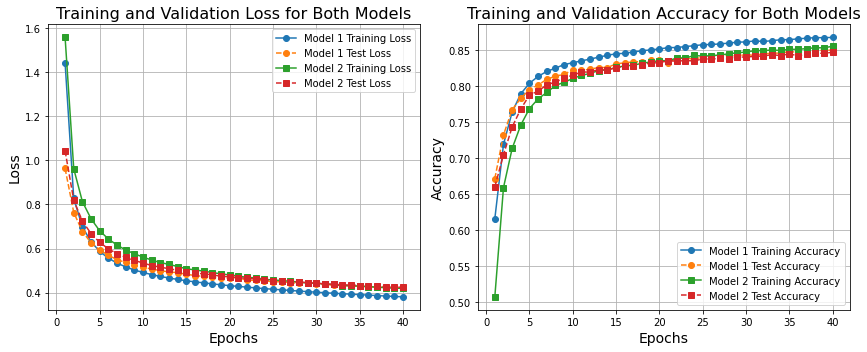

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='Model 2 Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='Model 2 Test Loss', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='Model 1 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='Model 1 Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='Model 2 Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='Model 2 Test Accuracy', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Histogram for first model

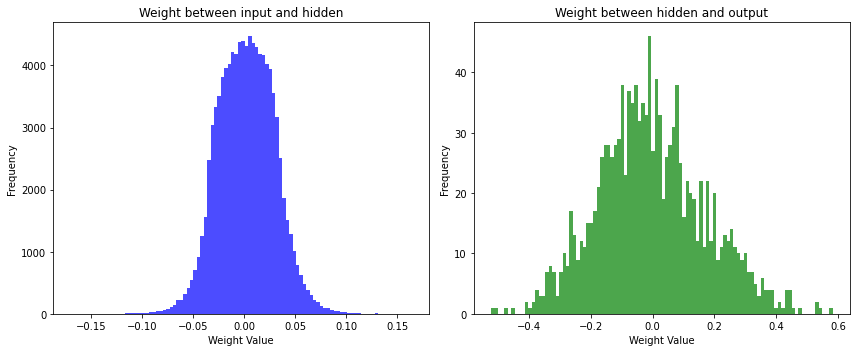

In [ ]:
weight_between_input_hidden = model_1.hidden_layer.weight.data.cpu().numpy().flatten()
weight_between_hidden_ouput = model_1.clf.weight.data.cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weight_between_input_hidden, bins=100, color='blue', alpha=0.7)
plt.title('Weight between input and hidden')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(weight_between_hidden_ouput, bins=100, color='green', alpha=0.7)
plt.title('Weight between hidden and output')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Histogram for second model

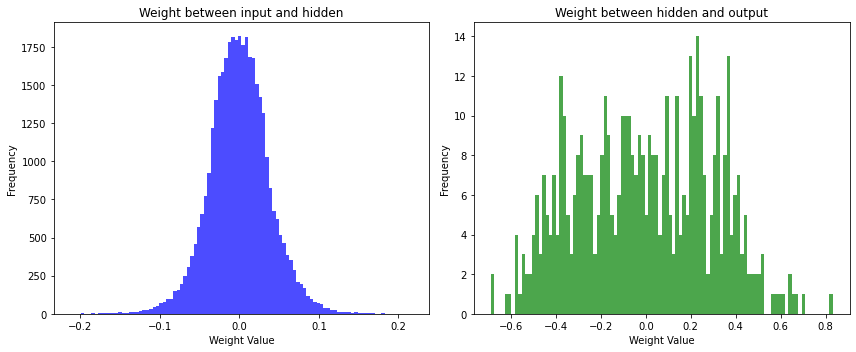

In [ ]:
weight_between_input_hidden = model_2.hidden_layer.weight.data.cpu().numpy().flatten()
weight_between_hidden_ouput = model_2.clf.weight.data.cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weight_between_input_hidden, bins=100, color='blue', alpha=0.7)
plt.title('Weight between input and hidden')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(weight_between_hidden_ouput, bins=100, color='green', alpha=0.7)
plt.title('Weight between hidden and output')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Adam

In [ ]:
model_1 = MLP_one_hidden_layer(hidden_dimension=128, drop_out=0)
model_1.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
model_2 = MLP_one_hidden_layer(hidden_dimension=48, drop_out=0.2)
model_2.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=48, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=48, out_features=10, bias=True)
)

In [ ]:
adam_optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-5, weight_decay=0)
adam_optimizer_2 = optim.Adam([
    {'params':[model_2.hidden_layer.weight], 'weight_decay':0.0001},
    {'params':[model_2.hidden_layer.bias, model_2.clf.bias, model_2.clf.weight], 'weight_decay': 0}
], lr=1e-5)

In [ ]:
epochs= 40
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=adam_optimizer_1, model=model_1, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.85, training_accuracy: 0.52
Test Loss: 1.47, Test Accuaracy: 0.64, Micro AUC: 0.94, F1 Micro: 0.64


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.24, training_accuracy: 0.67
Test Loss: 1.08, Test Accuaracy: 0.68, Micro AUC: 0.96, F1 Micro: 0.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.97, training_accuracy: 0.71
Test Loss: 0.91, Test Accuaracy: 0.71, Micro AUC: 0.97, F1 Micro: 0.71


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.84, training_accuracy: 0.74
Test Loss: 0.81, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.77, training_accuracy: 0.76
Test Loss: 0.75, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.71, training_accuracy: 0.77
Test Loss: 0.71, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.67, training_accuracy: 0.78
Test Loss: 0.68, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.64, training_accuracy: 0.79
Test Loss: 0.65, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.62, training_accuracy: 0.80
Test Loss: 0.63, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.58, training_accuracy: 0.81
Test Loss: 0.60, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.56, training_accuracy: 0.82
Test Loss: 0.58, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.49, training_accuracy: 0.84
Test Loss: 0.51, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.51, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.51, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


In [ ]:
epochs= 40
train_loss_2, train_acc_2, test_loss_2, test_acc_2, test_labels_2, test_preds_2 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=adam_optimizer_2, model=model_2, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 2.06, training_accuracy: 0.37
Test Loss: 1.82, Test Accuaracy: 0.63, Micro AUC: 0.92, F1 Micro: 0.63


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.64, training_accuracy: 0.60
Test Loss: 1.45, Test Accuaracy: 0.67, Micro AUC: 0.95, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.35, training_accuracy: 0.63
Test Loss: 1.20, Test Accuaracy: 0.67, Micro AUC: 0.95, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 1.17, training_accuracy: 0.64
Test Loss: 1.06, Test Accuaracy: 0.68, Micro AUC: 0.96, F1 Micro: 0.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 1.06, training_accuracy: 0.66
Test Loss: 0.96, Test Accuaracy: 0.69, Micro AUC: 0.96, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.98, training_accuracy: 0.67
Test Loss: 0.90, Test Accuaracy: 0.70, Micro AUC: 0.97, F1 Micro: 0.70


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.92, training_accuracy: 0.69
Test Loss: 0.85, Test Accuaracy: 0.71, Micro AUC: 0.97, F1 Micro: 0.71


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.88, training_accuracy: 0.70
Test Loss: 0.81, Test Accuaracy: 0.72, Micro AUC: 0.97, F1 Micro: 0.72


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.85, training_accuracy: 0.71
Test Loss: 0.78, Test Accuaracy: 0.73, Micro AUC: 0.97, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.82, training_accuracy: 0.72
Test Loss: 0.76, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.79, training_accuracy: 0.73
Test Loss: 0.73, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.77, training_accuracy: 0.73
Test Loss: 0.72, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.75, training_accuracy: 0.74
Test Loss: 0.70, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.74, training_accuracy: 0.75
Test Loss: 0.68, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.72, training_accuracy: 0.75
Test Loss: 0.67, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.71, training_accuracy: 0.76
Test Loss: 0.66, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.70, training_accuracy: 0.76
Test Loss: 0.65, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.68, training_accuracy: 0.77
Test Loss: 0.64, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.67, training_accuracy: 0.77
Test Loss: 0.63, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.67, training_accuracy: 0.77
Test Loss: 0.62, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.65, training_accuracy: 0.78
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.65, training_accuracy: 0.78
Test Loss: 0.61, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.64, training_accuracy: 0.79
Test Loss: 0.60, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.61, training_accuracy: 0.80
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.58, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


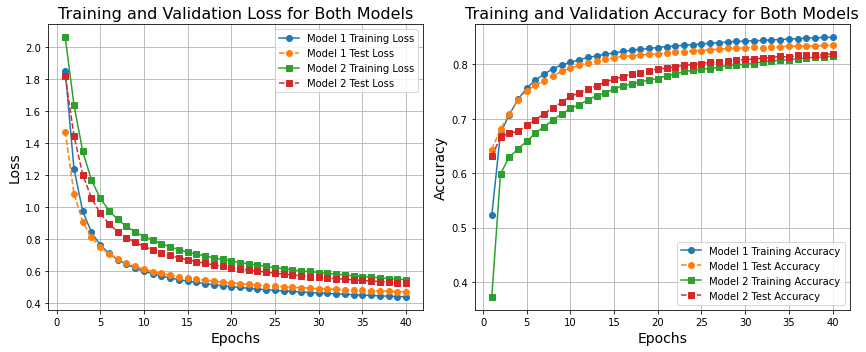

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='Model 2 Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='Model 2 Test Loss', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='Model 1 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='Model 1 Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='Model 2 Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='Model 2 Test Accuracy', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### RMSprop

In [ ]:
model_1 = MLP_one_hidden_layer(hidden_dimension=128, drop_out=0)
model_1.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=128, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
model_2 = MLP_one_hidden_layer(hidden_dimension=48, drop_out=0.2)
model_2.to(device=device)

MLP_one_hidden_layer(
  (hidden_layer): Linear(in_features=784, out_features=48, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (clf): Linear(in_features=48, out_features=10, bias=True)
)

In [ ]:
rms_optimizer_1 = optim.RMSprop(model_1.parameters(), lr=1e-5, weight_decay=0)
rms_optimizer_2 = optim.RMSprop([
    {'params':[model_2.hidden_layer.weight], 'weight_decay':0.0001},
    {'params':[model_2.hidden_layer.bias, model_2.clf.bias, model_2.clf.weight], 'weight_decay': 0}
], lr=1e-5)

In [ ]:
epochs= 40
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=rms_optimizer_1, model=model_1, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.75, training_accuracy: 0.57
Test Loss: 1.40, Test Accuaracy: 0.64, Micro AUC: 0.95, F1 Micro: 0.64


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.18, training_accuracy: 0.67
Test Loss: 1.03, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.93, training_accuracy: 0.70
Test Loss: 0.88, Test Accuaracy: 0.71, Micro AUC: 0.97, F1 Micro: 0.71


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.82, training_accuracy: 0.73
Test Loss: 0.79, Test Accuaracy: 0.73, Micro AUC: 0.97, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.75, training_accuracy: 0.75
Test Loss: 0.74, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.70, training_accuracy: 0.77
Test Loss: 0.70, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.67, training_accuracy: 0.78
Test Loss: 0.67, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.64, training_accuracy: 0.79
Test Loss: 0.65, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.62, training_accuracy: 0.80
Test Loss: 0.63, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.59, training_accuracy: 0.81
Test Loss: 0.60, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.49, training_accuracy: 0.84
Test Loss: 0.51, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.51, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.46, training_accuracy: 0.85
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


In [ ]:
epochs= 40
train_loss_2, train_acc_2, test_loss_2, test_acc_2, test_labels_2, test_preds_2 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=rms_optimizer_2, model=model_2, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 2.00, training_accuracy: 0.42
Test Loss: 1.76, Test Accuaracy: 0.53, Micro AUC: 0.89, F1 Micro: 0.53


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.58, training_accuracy: 0.54
Test Loss: 1.40, Test Accuaracy: 0.59, Micro AUC: 0.93, F1 Micro: 0.59


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.31, training_accuracy: 0.60
Test Loss: 1.18, Test Accuaracy: 0.64, Micro AUC: 0.95, F1 Micro: 0.64


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 1.14, training_accuracy: 0.63
Test Loss: 1.04, Test Accuaracy: 0.66, Micro AUC: 0.96, F1 Micro: 0.66


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 1.04, training_accuracy: 0.65
Test Loss: 0.95, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.96, training_accuracy: 0.67
Test Loss: 0.88, Test Accuaracy: 0.69, Micro AUC: 0.97, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.91, training_accuracy: 0.69
Test Loss: 0.84, Test Accuaracy: 0.71, Micro AUC: 0.97, F1 Micro: 0.71


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.87, training_accuracy: 0.70
Test Loss: 0.80, Test Accuaracy: 0.72, Micro AUC: 0.97, F1 Micro: 0.72


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.83, training_accuracy: 0.71
Test Loss: 0.77, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.81, training_accuracy: 0.72
Test Loss: 0.75, Test Accuaracy: 0.74, Micro AUC: 0.97, F1 Micro: 0.74


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.78, training_accuracy: 0.73
Test Loss: 0.73, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.76, training_accuracy: 0.74
Test Loss: 0.71, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.74, training_accuracy: 0.75
Test Loss: 0.69, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.73, training_accuracy: 0.76
Test Loss: 0.68, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.71, training_accuracy: 0.76
Test Loss: 0.67, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.70, training_accuracy: 0.76
Test Loss: 0.66, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.69, training_accuracy: 0.77
Test Loss: 0.65, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.68, training_accuracy: 0.77
Test Loss: 0.64, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.66, training_accuracy: 0.77
Test Loss: 0.63, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.66, training_accuracy: 0.78
Test Loss: 0.62, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.64, training_accuracy: 0.78
Test Loss: 0.61, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.64, training_accuracy: 0.78
Test Loss: 0.61, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.63, training_accuracy: 0.79
Test Loss: 0.60, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.59, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.61, training_accuracy: 0.80
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.61, training_accuracy: 0.80
Test Loss: 0.58, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.59, training_accuracy: 0.80
Test Loss: 0.57, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.58, training_accuracy: 0.80
Test Loss: 0.56, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.58, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.55, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


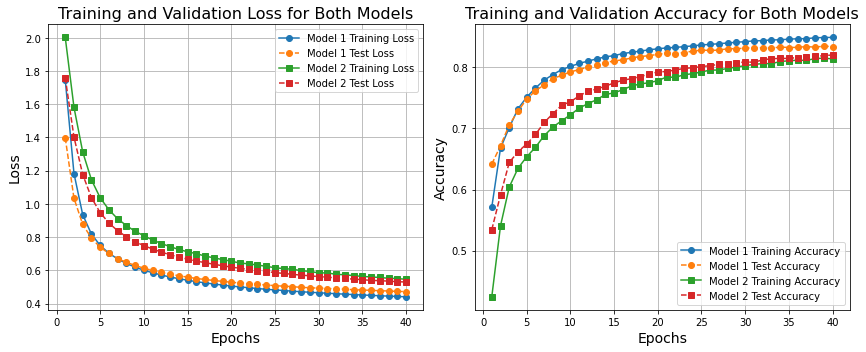

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='Model 1 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='Model 1 Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='Model 2 Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='Model 2 Test Loss', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='Model 1 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='Model 1 Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='Model 2 Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='Model 2 Test Accuracy', linestyle='--', marker='s')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Both Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Question 1-3
-   Implementing MLP with three hidden layers
-   Learning with Adam, Nadam, RMSprop
-   Baysian search

In [ ]:
class MLP_mine(nn.Module):
    def __init__(self, first_hidden_dimension:int, second_hidden_dimension:int, third_hidden_dimension:int, dropout:float) -> None:
        super().__init__()
        """
        This function will create an object for our model.
        Parameters:
            - first_hidden_dimension : first hidden layer dimension.
            - second_hidden_dimension: second hidden layer dimension.
            - third_hidden_dimension: third hidden layer dimension.
            - dropout : a float number specifing what precentage should be dropped.
        Return :
            Object of torch.nn
        """
        self.layer_1 = nn.Linear(28*28, first_hidden_dimension)
        self.bn1 = nn.BatchNorm1d(first_hidden_dimension)
        self.layer_2 = nn.Linear(first_hidden_dimension, second_hidden_dimension)
        self.bn2 = nn.BatchNorm1d(second_hidden_dimension)
        self.layer_3 = nn.Linear(second_hidden_dimension, third_hidden_dimension)
        self.bn3 = nn.BatchNorm1d(third_hidden_dimension)
        self.clf = nn.Linear(third_hidden_dimension, 10)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        for layer in [self.layer_1, self.layer_2, self.layer_3, self.clf]:
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Reshape the input to [batch_size, 28*28]
        Pass through layers
        Return the classes
        """
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.bn1(self.layer_1(x))))
        x = self.dropout(self.relu(self.bn2(self.layer_2(x))))
        x = self.dropout(self.relu(self.bn3(self.layer_3(x))))
        return self.clf(x)

### Adam

In [ ]:
mine_model = MLP_mine(
    first_hidden_dimension=256,
    second_hidden_dimension=128,
    third_hidden_dimension=64,
    dropout=0.2
)
mine_model.to(device=device)

MLP_mine(
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (clf): Linear(in_features=64, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
adam_optimizer = optim.Adam(params=mine_model.parameters(), lr=1e-5, weight_decay=0.0001)

In [ ]:
epochs= 40
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=adam_optimizer, model=mine_model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.93, training_accuracy: 0.35
Test Loss: 1.22, Test Accuaracy: 0.65, Micro AUC: 0.93, F1 Micro: 0.65


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.27, training_accuracy: 0.59
Test Loss: 0.95, Test Accuaracy: 0.73, Micro AUC: 0.96, F1 Micro: 0.73


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.05, training_accuracy: 0.68
Test Loss: 0.81, Test Accuaracy: 0.76, Micro AUC: 0.97, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.92, training_accuracy: 0.71
Test Loss: 0.73, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.84, training_accuracy: 0.74
Test Loss: 0.67, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.78, training_accuracy: 0.76
Test Loss: 0.62, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.73, training_accuracy: 0.77
Test Loss: 0.58, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.69, training_accuracy: 0.78
Test Loss: 0.56, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.66, training_accuracy: 0.79
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.64, training_accuracy: 0.80
Test Loss: 0.52, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.61, training_accuracy: 0.80
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.60, training_accuracy: 0.81
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.58, training_accuracy: 0.81
Test Loss: 0.48, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.57, training_accuracy: 0.82
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.44, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.44, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.49, training_accuracy: 0.84
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


### NAdam

In [ ]:
mine_model = MLP_mine(
    first_hidden_dimension=256,
    second_hidden_dimension=128,
    third_hidden_dimension=64,
    dropout=0.2
)
mine_model.to(device=device)

MLP_mine(
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (clf): Linear(in_features=64, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
nadam_optimizer = optim.NAdam(params=mine_model.parameters(), lr=1e-5, weight_decay=0.0001)

In [ ]:
epochs= 40
train_loss_2, train_acc_2, test_loss_2, test_acc_2, test_labels_2, test_preds_2 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=nadam_optimizer, model=mine_model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.88, training_accuracy: 0.37
Test Loss: 1.17, Test Accuaracy: 0.69, Micro AUC: 0.95, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.25, training_accuracy: 0.61
Test Loss: 0.93, Test Accuaracy: 0.75, Micro AUC: 0.97, F1 Micro: 0.75


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.05, training_accuracy: 0.68
Test Loss: 0.81, Test Accuaracy: 0.77, Micro AUC: 0.97, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.93, training_accuracy: 0.72
Test Loss: 0.73, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.85, training_accuracy: 0.74
Test Loss: 0.67, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.79, training_accuracy: 0.76
Test Loss: 0.63, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.74, training_accuracy: 0.77
Test Loss: 0.59, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.70, training_accuracy: 0.78
Test Loss: 0.56, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.67, training_accuracy: 0.79
Test Loss: 0.54, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.65, training_accuracy: 0.79
Test Loss: 0.52, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.62, training_accuracy: 0.80
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.59, training_accuracy: 0.81
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.55, training_accuracy: 0.82
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.44, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.44, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.49, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.37, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


### RMSprop

In [ ]:
mine_model = MLP_mine(
    first_hidden_dimension=256,
    second_hidden_dimension=128,
    third_hidden_dimension=64,
    dropout=0.2
)
mine_model.to(device=device)

MLP_mine(
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (clf): Linear(in_features=64, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
rmsprop_optimizer = optim.RMSprop(params=mine_model.parameters(), lr=1e-5, weight_decay=0.0001)

In [ ]:
epochs= 40
train_loss_3, train_acc_3, test_loss_3, test_acc_3, test_labels_3, test_preds_3 = training(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=rmsprop_optimizer, model=mine_model, epochs=epochs, loss_fn=loss_fn)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.72, training_accuracy: 0.42
Test Loss: 1.06, Test Accuaracy: 0.70, Micro AUC: 0.96, F1 Micro: 0.70


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.15, training_accuracy: 0.63
Test Loss: 0.84, Test Accuaracy: 0.76, Micro AUC: 0.97, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.96, training_accuracy: 0.70
Test Loss: 0.73, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.86, training_accuracy: 0.72
Test Loss: 0.66, Test Accuaracy: 0.79, Micro AUC: 0.98, F1 Micro: 0.79


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.79, training_accuracy: 0.75
Test Loss: 0.62, Test Accuaracy: 0.80, Micro AUC: 0.98, F1 Micro: 0.80


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.74, training_accuracy: 0.76
Test Loss: 0.58, Test Accuaracy: 0.81, Micro AUC: 0.98, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.70, training_accuracy: 0.77
Test Loss: 0.55, Test Accuaracy: 0.82, Micro AUC: 0.98, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.66, training_accuracy: 0.78
Test Loss: 0.53, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.65, training_accuracy: 0.79
Test Loss: 0.52, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.62, training_accuracy: 0.79
Test Loss: 0.50, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.60, training_accuracy: 0.80
Test Loss: 0.49, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.59, training_accuracy: 0.81
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.57, training_accuracy: 0.81
Test Loss: 0.47, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.56, training_accuracy: 0.81
Test Loss: 0.46, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.44, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.52, training_accuracy: 0.82
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.52, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.51, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 20, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 21, training_loss: 0.50, training_accuracy: 0.83
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 22, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 23, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 24, training_loss: 0.48, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 25, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 26, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 27, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 28, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 29, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 30, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 31, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 32, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 33, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 34, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 35, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 36, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 37, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 38, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 39, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.37, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


### Evaluation

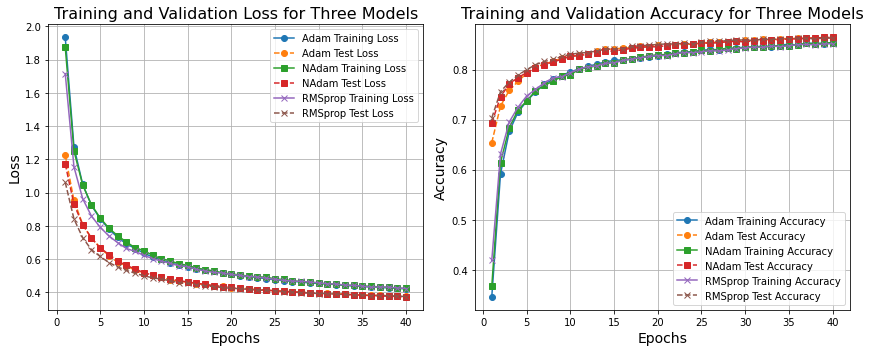

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='Adam Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='Adam Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='NAdam Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='NAdam Test Loss', linestyle='--', marker='s')
plt.plot(epochs, train_loss_3, label='RMSprop Training Loss', linestyle='-', marker='x')
plt.plot(epochs, test_loss_3, label='RMSprop Test Loss', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='Adam Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='Adam Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='NAdam Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='NAdam Test Accuracy', linestyle='--', marker='s')
plt.plot(epochs, train_acc_3, label='RMSprop Training Accuracy', linestyle='-', marker='x')
plt.plot(epochs, test_acc_3, label='RMSprop Test Accuracy', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Bayes Search

#### Create an objective

In [ ]:
def bayes_test(dataloader:DataLoader, model:nn.Module, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = loss_fn(preds, labels.to(torch.long))
            test_loss += loss.item()
            probs = F.softmax(preds, dim=1)
            _, predicted_indices = torch.max(preds, dim=1)
            all_preds.extend(predicted_indices.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return test_loss/len(dataloader), accuracy

def bayes_train(train_loader:DataLoader, test_loader:DataLoader, optimizer:optim, model:nn.Module, epochs:int, loss_fn):
    model.train()
    for epoch in range(epochs):
        training_loss = 0.0
        model.train()

        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = loss_fn(preds, labels.to(torch.long))
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        test_loss, test_acc = bayes_test(test_loader, model, loss_fn)
    return test_acc

In [ ]:
def objective(opt, learning_rate, dropout, epochs):
    model = MLP_mine(
        first_hidden_dimension=256,
        second_hidden_dimension=128,
        third_hidden_dimension=64,
        dropout=dropout
    ).to(device)
    optimizer = (
        optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
        if int(opt) == 0 else
        optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
        if int(opt) == 1 else
        optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    )

    loss_fn = nn.CrossEntropyLoss()
    test_acc = bayes_train(train_loader=train_dataloader, test_loader=test_dataloader, optimizer=optimizer, model=model, epochs=int(epochs), loss_fn=loss_fn)

    return test_acc

In [ ]:
pbounds = {
    'opt': (-1, 3),
    'learning_rate': (1e-5, 1e-1),
    'dropout': (0.2, 0.5),
    'epochs': (5, 15)
}

In [ ]:
optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25,)

|   iter    |  target   |  dropout  |  epochs   | learni... |    opt    |
-------------------------------------------------------------------------
| 1         | 0.6826    | 0.3124    | 14.51     | 0.0732    | 1.395     |
| 2         | 0.8335    | 0.2468    | 6.56      | 0.005818  | 2.465     |
| 3         | 0.8695    | 0.3803    | 12.08     | 0.002068  | 2.88      |
| 4         | 0.8093    | 0.4497    | 7.123     | 0.01819   | -0.2664   |
| 5         | 0.734     | 0.2913    | 10.25     | 0.0432    | 0.1649    |
| 6         | 0.8202    | 0.3943    | 12.02     | 0.01762   | 2.889     |
| 7         | 0.8687    | 0.4197    | 12.11     | 0.002144  | 2.993     |
| 8         | 0.733     | 0.2013    | 5.404     | 0.04665   | 0.4084    |
| 9         | 0.7343    | 0.2951    | 12.24     | 0.05577   | 2.912     |
| 10        | 0.4976    | 0.4905    | 12.11     | 0.09871   | 2.961     |
| 11        | 0.7368    | 0.4815    | 12.06     | 0.04502   | 2.994     |
| 12        | 0.7978    | 0.4326    | 

# Question 1-4

In [ ]:
class good_MLP(nn.Module):
    def __init__(self, first_size:int, second_size:int, third_size:int, dropout:float) -> None:
        """
        This function will create an object for our model.
        Parameters:
            - first_size : first hidden layer dimension.
            - second_size: second hidden layer dimension.
            - third_size: third hidden layer dimension.
            - dropout : a float number specifing what precentage should be dropped.
        Return :
            Object of torch.nn
        """
        super().__init__()
        self.first_layer = nn.Linear(28*28, first_size)
        self.second_layer = nn.Linear(first_size, second_size)
        self.third_layer = nn.Linear(second_size, third_size)
        self.clf = nn.Linear(third_size, 10)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Reshape the input to [batch_size, 28*28]
        Pass through layers
        Return the classes
        """
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.first_layer(x)))
        x = self.dropout(self.relu(self.second_layer(x)))
        x = self.dropout(self.relu(self.third_layer(x)))
        return self.clf(x)

### Learning Rate Variation

#### lr = 1e-2

In [ ]:
my_model = good_MLP(first_size=512, second_size=256, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=256, bias=True)
  (third_layer): Linear(in_features=256, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-2, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.21, training_accuracy: 0.54
Test Loss: 0.79, Test Accuaracy: 0.68, Micro AUC: 0.97, F1 Micro: 0.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 1.19, training_accuracy: 0.56
Test Loss: 0.86, Test Accuaracy: 0.69, Micro AUC: 0.96, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 1.29, training_accuracy: 0.53
Test Loss: 0.81, Test Accuaracy: 0.70, Micro AUC: 0.96, F1 Micro: 0.70


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 1.30, training_accuracy: 0.50
Test Loss: 0.85, Test Accuaracy: 0.67, Micro AUC: 0.96, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 1.31, training_accuracy: 0.49
Test Loss: 0.79, Test Accuaracy: 0.69, Micro AUC: 0.97, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 1.35, training_accuracy: 0.47
Test Loss: 0.77, Test Accuaracy: 0.69, Micro AUC: 0.97, F1 Micro: 0.69


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 1.38, training_accuracy: 0.47
Test Loss: 1.06, Test Accuaracy: 0.61, Micro AUC: 0.94, F1 Micro: 0.61


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 1.41, training_accuracy: 0.46
Test Loss: 0.88, Test Accuaracy: 0.70, Micro AUC: 0.96, F1 Micro: 0.70


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 1.44, training_accuracy: 0.46
Test Loss: 1.00, Test Accuaracy: 0.67, Micro AUC: 0.95, F1 Micro: 0.67


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 1.43, training_accuracy: 0.46
Test Loss: 0.98, Test Accuaracy: 0.68, Micro AUC: 0.95, F1 Micro: 0.68


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 1.43, training_accuracy: 0.45
Test Loss: 0.98, Test Accuaracy: 0.66, Micro AUC: 0.95, F1 Micro: 0.66


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 1.41, training_accuracy: 0.46
Test Loss: 1.08, Test Accuaracy: 0.61, Micro AUC: 0.94, F1 Micro: 0.61


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 1.46, training_accuracy: 0.44
Test Loss: 1.08, Test Accuaracy: 0.53, Micro AUC: 0.93, F1 Micro: 0.53


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 1.46, training_accuracy: 0.44
Test Loss: 0.99, Test Accuaracy: 0.63, Micro AUC: 0.95, F1 Micro: 0.63


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 1.44, training_accuracy: 0.45
Test Loss: 1.07, Test Accuaracy: 0.65, Micro AUC: 0.94, F1 Micro: 0.65


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 1.45, training_accuracy: 0.45
Test Loss: 1.04, Test Accuaracy: 0.60, Micro AUC: 0.94, F1 Micro: 0.60


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 1.47, training_accuracy: 0.44
Test Loss: 1.04, Test Accuaracy: 0.60, Micro AUC: 0.94, F1 Micro: 0.60


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 1.52, training_accuracy: 0.42
Test Loss: 1.11, Test Accuaracy: 0.59, Micro AUC: 0.94, F1 Micro: 0.59


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 1.65, training_accuracy: 0.37
Test Loss: 1.16, Test Accuaracy: 0.51, Micro AUC: 0.93, F1 Micro: 0.51


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 1.64, training_accuracy: 0.37
Test Loss: 1.27, Test Accuaracy: 0.50, Micro AUC: 0.91, F1 Micro: 0.50


#### lr=1e-*3*

In [ ]:
my_model = good_MLP(first_size=512, second_size=256, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=256, bias=True)
  (third_layer): Linear(in_features=256, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_2, train_acc_2, test_loss_2, test_acc_2, test_labels_2, test_preds_2 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-3, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 0.71, training_accuracy: 0.74
Test Loss: 0.48, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.51, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.40, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.37, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.41, training_accuracy: 0.85
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.38, training_accuracy: 0.86
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.38, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


#### lr=1e-4

In [ ]:
my_model = good_MLP(first_size=512, second_size=256, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=256, bias=True)
  (third_layer): Linear(in_features=256, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_3, train_acc_3, test_loss_3, test_acc_3, test_labels_3, test_preds_3 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.13, training_accuracy: 0.58
Test Loss: 0.64, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.65, training_accuracy: 0.77
Test Loss: 0.52, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.55, training_accuracy: 0.81
Test Loss: 0.47, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.44, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.46, training_accuracy: 0.84
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.44, training_accuracy: 0.85
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.42, training_accuracy: 0.86
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.38, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.37, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.36, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.34, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.33, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


#### Evaluation

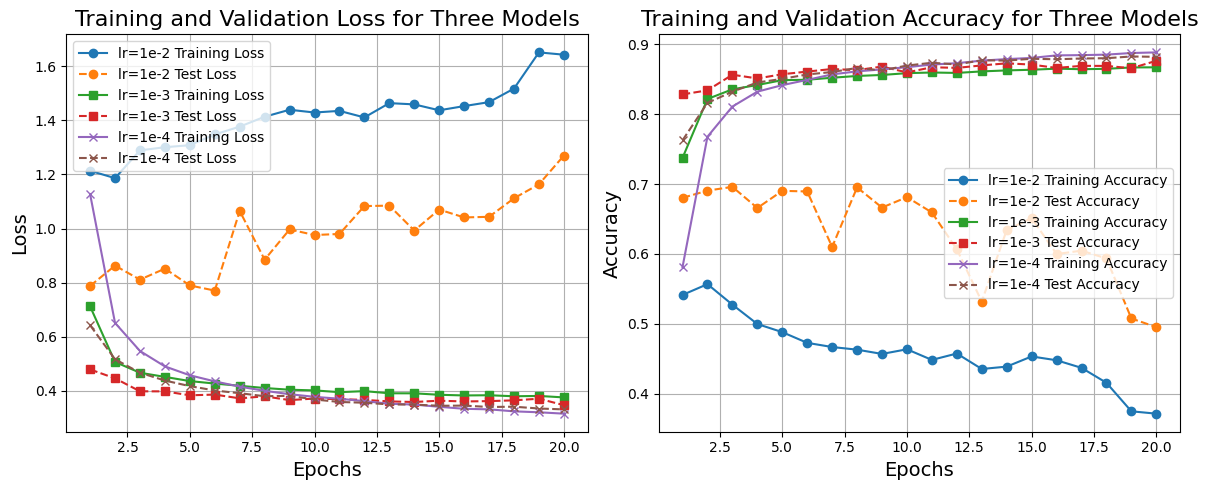

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='lr=1e-2 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='lr=1e-2 Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='lr=1e-3 Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='lr=1e-3 Test Loss', linestyle='--', marker='s')
plt.plot(epochs, train_loss_3, label='lr=1e-4 Training Loss', linestyle='-', marker='x')
plt.plot(epochs, test_loss_3, label='lr=1e-4 Test Loss', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='lr=1e-2 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='lr=1e-2 Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='lr=1e-3 Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='lr=1e-3 Test Accuracy', linestyle='--', marker='s')
plt.plot(epochs, train_acc_3, label='lr=1e-4 Training Accuracy', linestyle='-', marker='x')
plt.plot(epochs, test_acc_3, label='lr=1e-4 Test Accuracy', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Confusion Matrix for each model

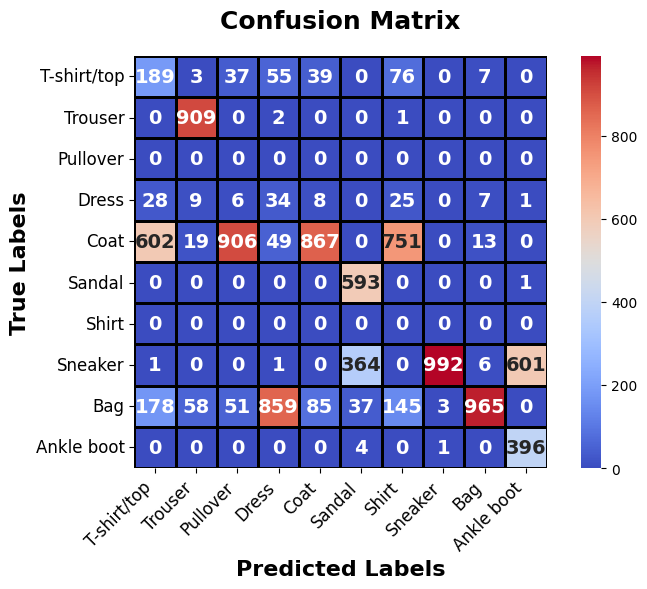

In [ ]:
cf_matrix = confusion_matrix(test_labels_1, test_preds_1)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

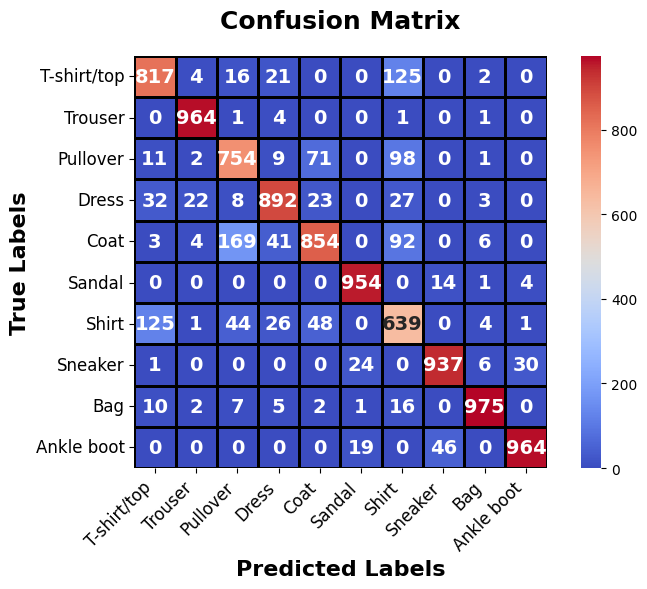

In [ ]:
cf_matrix = confusion_matrix(test_labels_2, test_preds_2)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

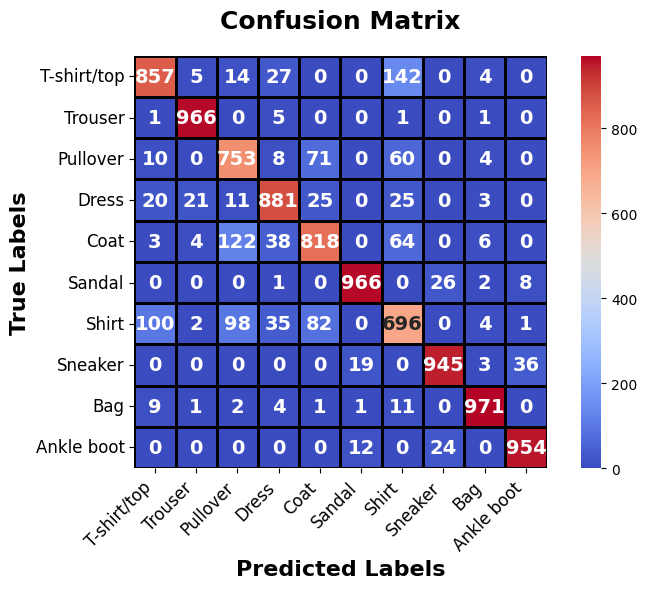

In [ ]:
cf_matrix = confusion_matrix(test_labels_3, test_preds_3)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

### Neurons Variations

#### Second Dimension = 400

In [ ]:
my_model = good_MLP(first_size=512, second_size=400, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=400, bias=True)
  (third_layer): Linear(in_features=400, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_1, train_acc_1, test_loss_1, test_acc_1, test_labels_1, test_preds_1 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.08, training_accuracy: 0.60
Test Loss: 0.62, Test Accuaracy: 0.77, Micro AUC: 0.98, F1 Micro: 0.77


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.62, training_accuracy: 0.78
Test Loss: 0.50, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.53, training_accuracy: 0.82
Test Loss: 0.45, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.44, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.42, training_accuracy: 0.85
Test Loss: 0.40, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.37, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.36, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.34, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.31, training_accuracy: 0.89
Test Loss: 0.33, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.31, training_accuracy: 0.89
Test Loss: 0.33, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


#### Second Dimension = 256

In [ ]:
my_model = good_MLP(first_size=512, second_size=256, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=256, bias=True)
  (third_layer): Linear(in_features=256, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_2, train_acc_2, test_loss_2, test_acc2, test_labels_2, test_preds_2 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.13, training_accuracy: 0.57
Test Loss: 0.63, Test Accuaracy: 0.76, Micro AUC: 0.98, F1 Micro: 0.76


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.64, training_accuracy: 0.77
Test Loss: 0.51, Test Accuaracy: 0.81, Micro AUC: 0.99, F1 Micro: 0.81


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.54, training_accuracy: 0.81
Test Loss: 0.46, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.48, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.45, training_accuracy: 0.84
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.40, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.38, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.39, training_accuracy: 0.86
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.36, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.36, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.34, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.32, training_accuracy: 0.89
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.31, training_accuracy: 0.89
Test Loss: 0.33, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


#### Second Dimension = 128

In [ ]:
my_model = good_MLP(first_size=512, second_size=128, third_size=128, dropout=0.5)
my_model.to(device)

good_MLP(
  (first_layer): Linear(in_features=784, out_features=512, bias=True)
  (second_layer): Linear(in_features=512, out_features=128, bias=True)
  (third_layer): Linear(in_features=128, out_features=128, bias=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
epochs = 20
train_loss_3, train_acc_3, test_loss_3, test_acc3, test_labels_3, test_preds_3 = training(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    optimizer=optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-4),
    model=my_model,
    epochs=epochs,
    loss_fn=loss_fn
)

  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 0, training_loss: 1.23, training_accuracy: 0.53
Test Loss: 0.71, Test Accuaracy: 0.72, Micro AUC: 0.97, F1 Micro: 0.72


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 1, training_loss: 0.73, training_accuracy: 0.73
Test Loss: 0.56, Test Accuaracy: 0.78, Micro AUC: 0.98, F1 Micro: 0.78


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 2, training_loss: 0.60, training_accuracy: 0.79
Test Loss: 0.49, Test Accuaracy: 0.82, Micro AUC: 0.99, F1 Micro: 0.82


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 3, training_loss: 0.54, training_accuracy: 0.82
Test Loss: 0.46, Test Accuaracy: 0.83, Micro AUC: 0.99, F1 Micro: 0.83


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 4, training_loss: 0.49, training_accuracy: 0.83
Test Loss: 0.43, Test Accuaracy: 0.84, Micro AUC: 0.99, F1 Micro: 0.84


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 5, training_loss: 0.47, training_accuracy: 0.84
Test Loss: 0.42, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 6, training_loss: 0.45, training_accuracy: 0.85
Test Loss: 0.41, Test Accuaracy: 0.85, Micro AUC: 0.99, F1 Micro: 0.85


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 7, training_loss: 0.43, training_accuracy: 0.85
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 8, training_loss: 0.41, training_accuracy: 0.86
Test Loss: 0.39, Test Accuaracy: 0.86, Micro AUC: 0.99, F1 Micro: 0.86


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 9, training_loss: 0.40, training_accuracy: 0.86
Test Loss: 0.38, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 10, training_loss: 0.39, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 11, training_loss: 0.38, training_accuracy: 0.87
Test Loss: 0.37, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 12, training_loss: 0.37, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.87, Micro AUC: 0.99, F1 Micro: 0.87


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 13, training_loss: 0.37, training_accuracy: 0.87
Test Loss: 0.36, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 14, training_loss: 0.36, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 15, training_loss: 0.36, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 16, training_loss: 0.35, training_accuracy: 0.88
Test Loss: 0.35, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 17, training_loss: 0.34, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 18, training_loss: 0.34, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch: 19, training_loss: 0.33, training_accuracy: 0.88
Test Loss: 0.34, Test Accuaracy: 0.88, Micro AUC: 0.99, F1 Micro: 0.88


#### Evaluation

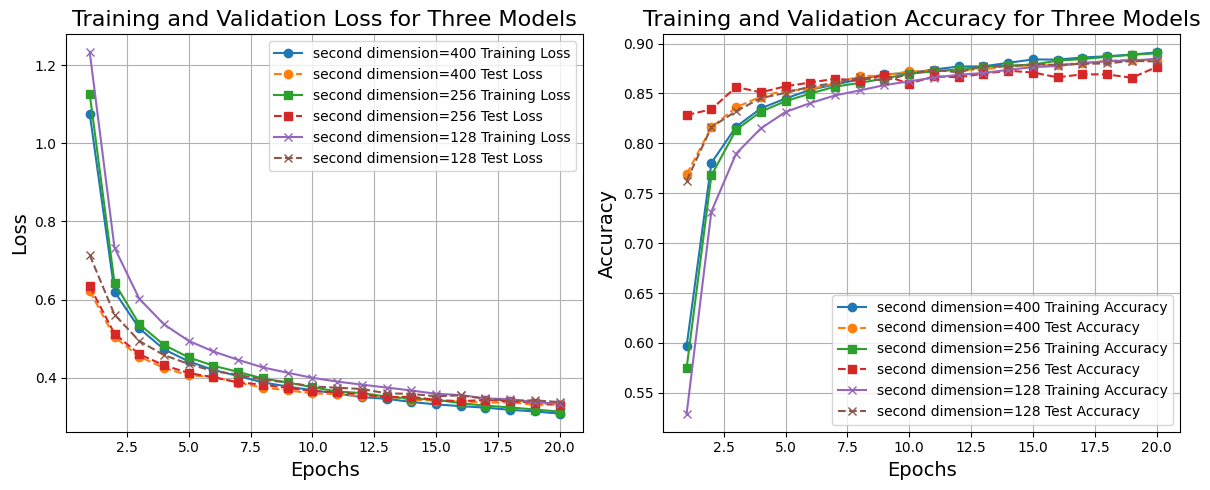

In [ ]:
epochs = range(1, len(train_loss_1) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_1, label='second dimension=400 Training Loss', linestyle='-', marker='o')
plt.plot(epochs, test_loss_1, label='second dimension=400 Test Loss', linestyle='--', marker='o')
plt.plot(epochs, train_loss_2, label='second dimension=256 Training Loss', linestyle='-', marker='s')
plt.plot(epochs, test_loss_2, label='second dimension=256 Test Loss', linestyle='--', marker='s')
plt.plot(epochs, train_loss_3, label='second dimension=128 Training Loss', linestyle='-', marker='x')
plt.plot(epochs, test_loss_3, label='second dimension=128 Test Loss', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_1, label='second dimension=400 Training Accuracy', linestyle='-', marker='o')
plt.plot(epochs, test_acc_1, label='second dimension=400 Test Accuracy', linestyle='--', marker='o')
plt.plot(epochs, train_acc_2, label='second dimension=256 Training Accuracy', linestyle='-', marker='s')
plt.plot(epochs, test_acc_2, label='second dimension=256 Test Accuracy', linestyle='--', marker='s')
plt.plot(epochs, train_acc_3, label='second dimension=128 Training Accuracy', linestyle='-', marker='x')
plt.plot(epochs, test_acc_3, label='second dimension=128 Test Accuracy', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy for Three Models', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Confusion Matrixes

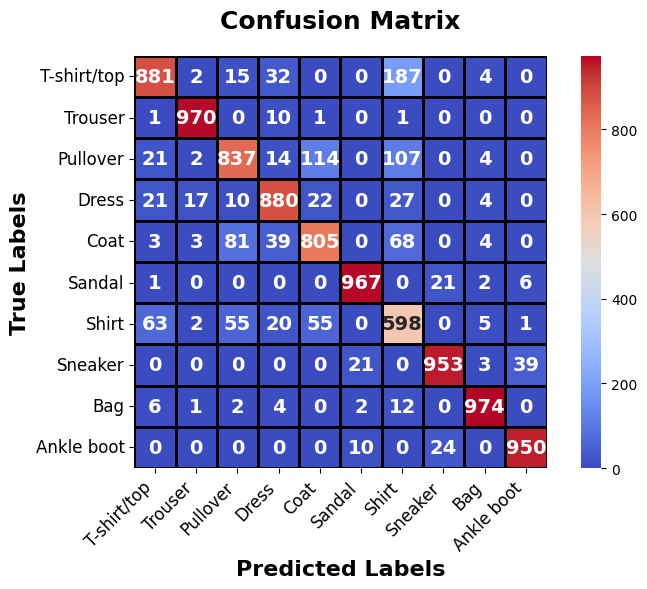

In [ ]:
cf_matrix = confusion_matrix(test_labels_1, test_preds_1)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

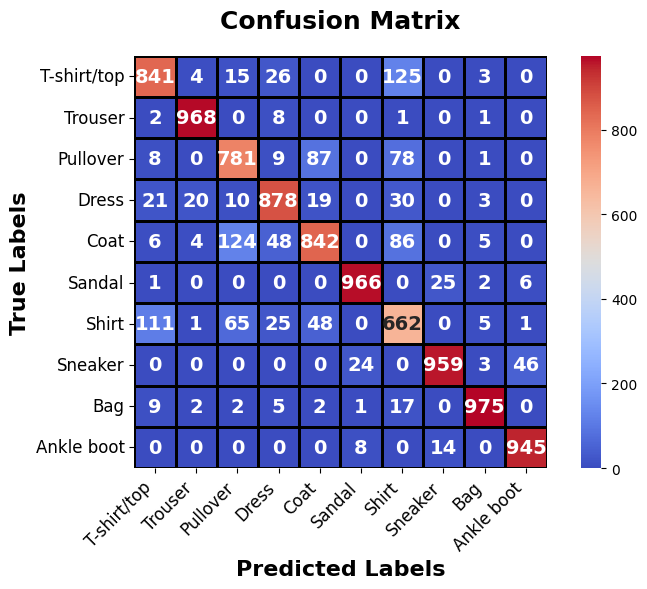

In [ ]:
cf_matrix = confusion_matrix(test_labels_2, test_preds_2)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

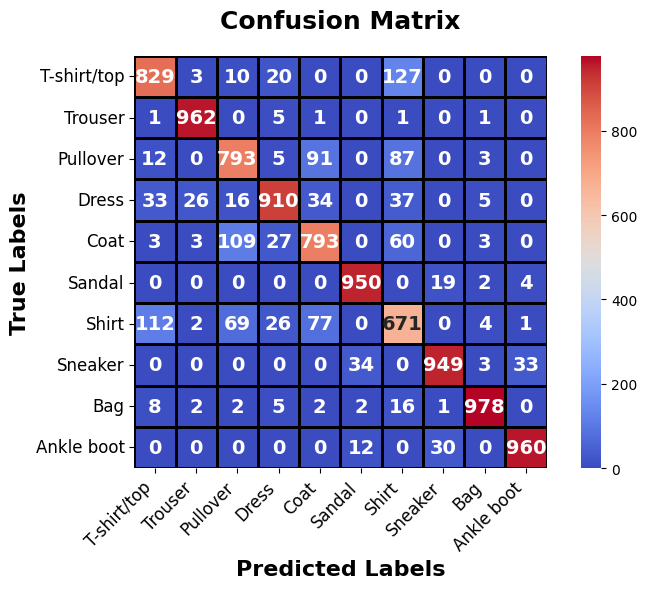

In [ ]:
cf_matrix = confusion_matrix(test_labels_3, test_preds_3)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

## Randomized Search

In [29]:
class random_model(nn.Module):
    def __init__(self, n_layers:int, first_dimension:int, second_dimension:int) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(28*28, first_dimension))
        if n_layers == 1:
          self.layers.append(nn.Linear(first_dimension, 10))
        elif n_layers == 2:
          self.layers.append(nn.Linear(first_dimension, second_dimension))
          self.layers.append(nn.Linear(second_dimension, 10))
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        for layer in self.layers[:-1]:
            x = self.dropout(self.act(layer(x)))
        x = self.layers[-1](x)
        return x

In [30]:
X = train_dataset.data.float().view(-1, 28*28)
y = train_dataset.targets
assert X.shape[0] == y.shape[0]

In [31]:
model = NeuralNetClassifier(
    random_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    max_epochs=20,
    batch_size=64,
    verbose=False
)

In [32]:
param_grid = {
    'optimizer__lr': [1e-3,1e-4],
    'module__n_layers': [1, 2],
    'module__first_dimension': [128, 256, 512],
    'module__second_dimension': [32, 64, 128],
}

In [33]:
rs_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, verbose=2, cv=2, n_iter=10)
rs_search.fit(X, y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.random_model'>,
),
                   n_jobs=-1,
                   param_distributions={'module__first_dimension': [128, 256,
                                                                    512],
                                        'module__n_layers': [1, 2],
                                        'module__second_dimension': [32, 64,
                                                                     128],
                                        'optimizer__lr': [0.001, 0.0001]},
                   verbose=2)

In [34]:
print(f"The best parameters are: {rs_search.best_params_}")

The best parameters are: {'optimizer__lr': 0.0001, 'module__second_dimension': 128, 'module__n_layers': 1, 'module__first_dimension': 512}


In [35]:
y_preds = rs_search.predict(test_set.data.float().view(-1, 28*28))

In [36]:
print(f'Accuracy score is: {accuracy_score(test_set.targets, y_preds)}')

Accuracy score is: 0.8761


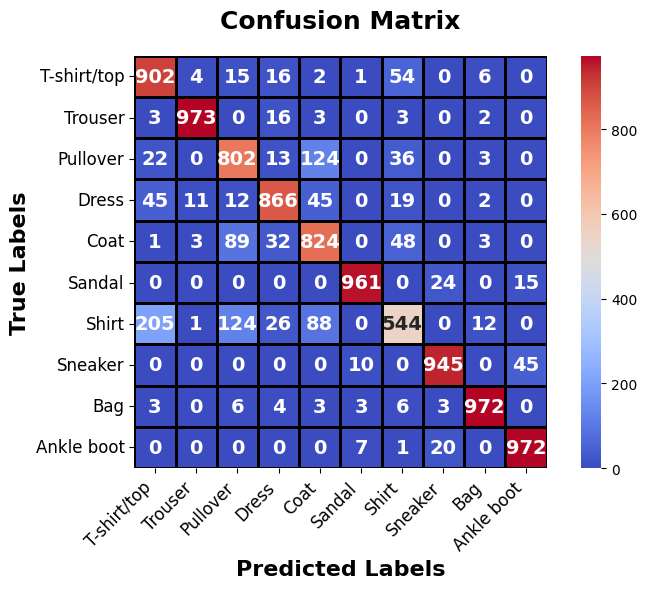

In [37]:
cf_matrix = confusion_matrix(test_set.targets, y_preds)
class_names = train_dataset.classes
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap=cmap, cbar=True, square=True,
            linewidths=1, linecolor='black', annot_kws={"size": 14, "weight": "bold"},
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=16, weight='bold')
plt.ylabel('True Labels', fontsize=16, weight='bold')
plt.title('Confusion Matrix', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()